# Lógica Computacional

## Trabalho Prático 1
#### Grupo 20
* Francisco Domingos Martins Oliveira,  A82066
* José Luís Cerqueira Pires, A84552

Vamos começar por importar as ferramentas necessárias em todo o Notebook.

In [1]:
from pyscipopt import Model, quicksum, quickprod
import networkx as nx
import numpy as np
import random


O problema tem duas partes:
1. Gerar aleatoriamente um grafo, de acordo com as seguintes restrições:
 * O grafo tem ser orientado ligado. 
 * Os nodos denotam pontos de acesso e  os arcos denotam vias de comunicação só com um sentido.
 * Cada nodo tem um número aleatório de descendentes no intervalo $\,1..d\,$  cujos destinos são também gerados aleatoriamente.
2. Determinar o maior número dea arestas que é possível remover mantendo o grafo ligado.

### Exercício 1 - Parte a)

Vamos começar pela parte a).

A seguinte função gera um grafo com as restrições pedidas:

In [2]:
def random_graph(N,D):
    # Criar um grafo orientado
    grafo = nx.DiGraph()
    
    
    # Listar os vértices do grafo
    nodes = list(range(N))
   
    
    # Adicionar os vértices ao grafo
    grafo.add_nodes_from(nodes)
    
    # Ordenar aleatóriamente a lista de vértices
    random_nodes = list(nodes)
    random.shuffle(random_nodes)

    
    # Cada vértice irá se ligar a um vértice aleatório e o último vértice da lista irá ligar-se ao primeiro
    for node in range(N):
        grafo.add_edge(random_nodes[node], random_nodes[(node+1) % N])
    
    
    # Gerar arestas restantes  
    for node in range(N):

        # Criar uma lista para todos os nodos possiveis 
        nodes_possiveis = []
        
        for s in range(len(nodes)):
            if(node!=s):
                # Se já tiver uma aresta entre dois nodos não a vai adicionar 
                if(grafo.has_edge(node,s) or grafo.has_edge(s,node)):
                    continue 
                else : 
                    nodes_possiveis.append(s)
                
        
        # Baralhar todos nodos possiveis 
        random.shuffle(nodes_possiveis)
        
        # Máximo de D-1 arestas para criar
        num_adjacentes = random.choice(list(range(D)))
        
            
        for _ in range(num_adjacentes):
            # Verificar se existem nodos disponiveis
            if len(nodes_possiveis) == 0:
                break
            
            # Adicionar a aresta na posição 0 ao vértice atual 
            grafo.add_edge(node, nodes_possiveis[0])
            # Remover o nodo adicionado dos possiveis 
            del nodes_possiveis[0]
            # Baralhar o resto dos nodos possiveis 
            random.shuffle(nodes_possiveis)
            
    return grafo
         
    

Iremos mostrar agora alguns exemplos de grafos: 

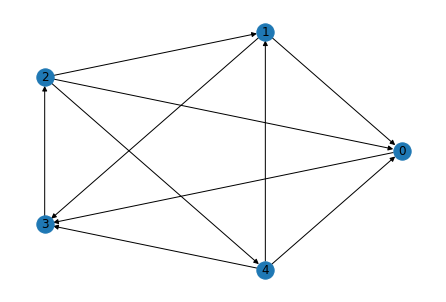

In [3]:
N,D =5,5
grafo = random_graph(N,D)
nx.draw_circular(grafo, with_labels = True)

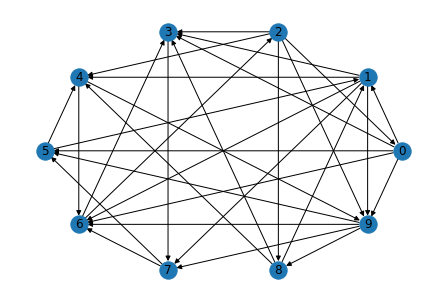

In [4]:
N,D =10,5
grafo1 = random_graph(N,D)
nx.draw_circular(grafo1, with_labels = True)

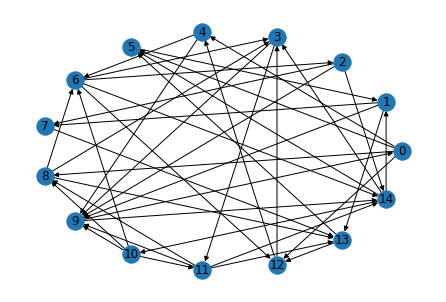

In [5]:
N,D =15 , 4
grafo2 = random_graph(N,D)
nx.draw_circular(grafo2, with_labels = True)

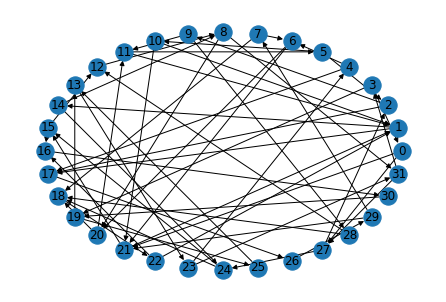

In [6]:
N,D =32 , 2
grafo3 = random_graph(N,D)
nx.draw_circular(grafo3, with_labels = True)

### Exercício 1 - Parte b)

Seja G = (V, E).

Definimos as seguintes variáveis:

$\forall_{e \in E}{x_e}$ 
, onde $x_e$ é uma variável binária que é verdadeira sse existe a aresta **e**.
 

$\forall_{e \in E}{z_e}$ 
, onde $z_e$ é uma variável auxiliar cujo valor é descrito abaixo.

O nosso objetivo é minimizar o número de arestas. Assim o objetivo é: $ min\ \sum_{e \in E}{x_e} $.

As restrições que obtivemos foram as seguintes:

1. Para quaisquer dois vértices **u,v**, existe pelo menos um caminho entre **u** e **v**:


$\forall_{u\,\in\,V}\,\,\forall_{v\,\in\,V} \sum_{p\,\in\,ap(u,v)}\,\,(\bigwedge_{(e_0,e_1)\,\in\,p}\,x_{e_0,e_1})$  

 
 (Onde ap corresponde ao conjuntos dos caminhos possiveis entre dois pontos)
 
2. A variável auxiliar $z_{u,v}$ é verdadeira sse a conjunção $\bigwedge_{(e_0,e_1)\,\in\,p}\,x_{e_0,e_1}$ acima mencionada é verdadeira.

Assim sendo, temos a seguinte função:

In [7]:
#transforma uma lista de vertices em uma lista de arestas 
def pathtoar(l):
    res=[]
    for i in range(len(l)-1):
        res.append((l[i],l[i+1]))
    return res

def mingraph(graph):
    m = Model()
    N = len(graph)
    x = {}
    
    for (o,d) in graph.edges():
        if o not in x:
            x[o] = {}
        x[o][d] = m.addVar(str(o)+str(d), vtype='B') 
    
    z = {}
    for o in graph:
        z[o] = {}
        
        for d in range(o + 1, o + N):
            z[o][d] = []
            
            sp = nx.all_simple_paths(graph, source=o, target=d % N, cutoff=N)
            for path in sp:
                y = m.addVar('existe caminho'+str(o)+str(d), vtype='B')
                caminhos = pathtoar(path)
                m.addConsAnd([x[a][b] for a,b in caminhos],y)
                z[o][d].append(y)
            # tem de existir pelo menos um caminho entre a origem e o destino
            m.addCons(quicksum(z[o][d]) >= 1)

    

    # minimiza o somatorio do numero total de arestas 
    T = quicksum([quicksum(v.values()) for v in x.values()])
    m.setObjective(T, 'minimize')
    m.optimize()
    
    #cria um novo grafo 
    graph_res = nx.DiGraph()
    #se a aresta for ==1 coloca a mesma no novo grafo 
    for (a,b) in graph.edges():
        if round(m.getVal(x[a][b]))==1:
            graph_res.add_edge(a,b)
    
    if m.getStatus() == 'optimal':
       
        print('foram removidos '+ str(int(len(graph.edges()) - m.getVal(T))))
        return graph_res
    else:
        return  graph



foram removidos 5


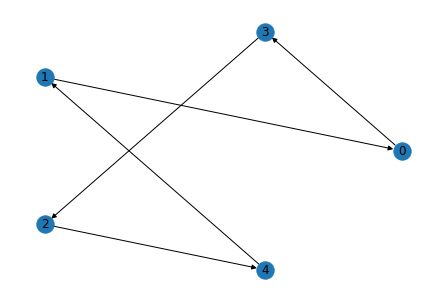

In [8]:
grafo_minimo = mingraph(grafo)
nx.draw_circular(grafo_minimo, with_labels = True)


foram removidos 21


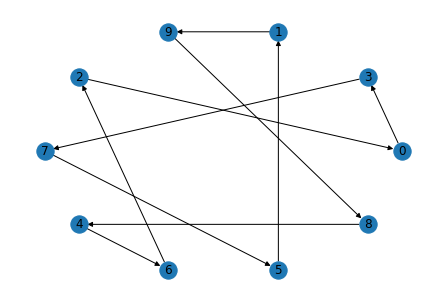

In [9]:
grafo_minimo1 = mingraph(grafo1)
nx.draw_circular(grafo_minimo1, with_labels = True)

foram removidos 26


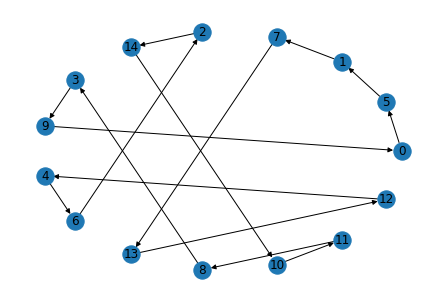

In [10]:
grafo_minimo2 = mingraph(grafo2)
nx.draw_circular(grafo_minimo2, with_labels = True)

foram removidos 24


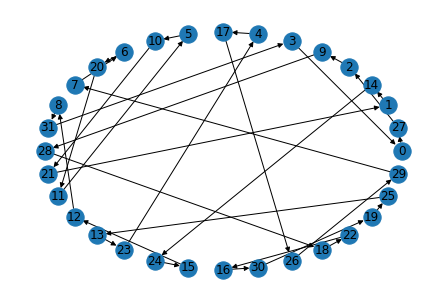

In [11]:
grafo_minimo3 = mingraph(grafo3)
nx.draw_circular(grafo_minimo3, with_labels = True)
